<a href="https://colab.research.google.com/github/karl-karlsson/notebooks/blob/main/CIA_factbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can open a copy of this notebook in Google Colab by clicking the icon above

---


# About the data

CIA publish and update 'The World Factbook' (see: https://www.cia.gov/the-world-factbook/) which contains facts about countries.

The dataset I use in this notebook is an excerpt from the factbook from 2015. The data, which comes as a SQLite database, can be found here: https://github.com/factbook/factbook.sql/

My personal motivation for doing this project is primarily to brush up some old SQL skills and  to checkout the `plotnine` library. `plotnine` is a Python translation of the R package `ggplot2` which has been a long time favorite of mine.

The project was originally a project that's part of the 'Data Engineer with Python' track on Dataquest ([link](https://www.dataquest.io/)). I've made some changes to the project, for example adding visualizations. If you want to check out the provided solutions to the original project you can find them [here](https://github.com/dataquestio/solutions/blob/master/Mission257Solutions.ipynb).  


# Downloading the data, firing up SQL magic and running some basic querys

First we'll download the file ´factbook.db´ from GitHub.

In [45]:
import urllib.request
import pandas as pd
import plotnine as gg

urllib.request.urlretrieve("https://github.com/factbook/factbook.sql/releases/download/v0.1/factbook.db", "factbook.db")

('factbook.db', <http.client.HTTPMessage at 0x7fd457d8a090>)

A nice feature with Jupyter notebooks (and Google Colab) is that you can use "SQL magic" to write SQL-querys. There are two variations. `%sql` interprets the code that follows on that *line*  a SQL commands and `%%sql` interprets the whole *cell* as SQL code.

In [46]:
%load_ext sql
%config SqlMagic.displaycon = False
%config SqlMagic.feedback = False

%sql sqlite:///factbook.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Config option `displaycon` not recognized by `SqlMagic`.  Did you mean `displaylimit`?
  


'Connected: @factbook.db'

We can start by checking out what tables are in the database.


In [47]:
%%sql 
SELECT *
  FROM sqlite_master
 WHERE type='table';

 * sqlite:///factbook.db


type,name,tbl_name,rootpage,sql
table,facts,facts,2,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float, ""created_at"" datetime, ""updated_at"" datetime)"
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"


As seen there is a table called ´facts´ within the db. This is the table we want to query.

Let's start by displaying the first five rows using SQL.

In [48]:
%%sql 
SELECT * 
FROM facts
LIMIT 5;

 * sqlite:///factbook.db


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


We also want to know how many rows (=countries) there are in the table.

In [49]:
%%sql SELECT COUNT(*) AS rows
FROM facts;

 * sqlite:///factbook.db


rows
261


There are 261 rows/countries in the table. This is a little bit strange since most internet sources state that (in 2022) there are actually 195 countries in the world. We'll investigate this a bit further down.

Of course this is a small dataset by most standards and one solution could of course be to just download the whole dataset and convert it into a Pandas dataframe.

In [50]:
a_dataframe = %sql SELECT * FROM facts;
a_dataframe = a_dataframe.DataFrame()
a_dataframe[:5]

 * sqlite:///factbook.db


,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748.0,27398.0,1350.0,3029278.0,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741.0,2381741.0,0.0,39542166.0,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468.0,468.0,0.0,85580.0,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700.0,1246700.0,0.0,19625353.0,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


But since the aim of this project are in part to brush up my SQL skills I'll stick to fetching data and doing calculations using SQL querys (however, for visualization purposes the data needs to be transformed to a dataframe).

# Extreme values

What country has the smallest population, the largets population, the lowest population growth and the highest population growth?

Let's find out.

In [51]:
%%sql 
/* SMALLEST POPULATION */
SELECT name, population, population_growth, 'smallest pop' AS what
FROM facts
WHERE population == 
/* Subquery start */ 
(SELECT 
MIN(population) 
FROM facts)
/* Sq. end */
UNION 
/* LARGEST POPULATION */
SELECT name, population, population_growth, 'largest pop' AS what
FROM facts
WHERE population == 
/* Subquery start */ 
(SELECT 
MAX(population) 
FROM facts)
/* Sq. end */
UNION 
/* LOWEST POPULATION GROWTH */
SELECT name, population, population_growth, 'lowest pop growth' AS what
FROM facts
WHERE population_growth == 
/* Subquery start */ 
(SELECT 
MIN(population_growth) 
FROM facts)
/* Sq. end */
UNION 
/* HIGHEST POPULATION GROWTH */
SELECT name, population, population_growth, 'highest pop growth' AS what
FROM facts
WHERE population_growth == 
/* Subquery start */ 
(SELECT 
MAX(population_growth) 
FROM facts)
/* Sq. end */
;



 * sqlite:///factbook.db


name,population,population_growth,what
Antarctica,0,None,smallest pop
Cocos (Keeling) Islands,596,0.0,lowest pop growth
Greenland,57733,0.0,lowest pop growth
Holy See (Vatican City),842,0.0,lowest pop growth
Pitcairn Islands,48,0.0,lowest pop growth
South Sudan,12042910,4.02,highest pop growth
World,7256490011,1.08,largest pop


Some interesting things. First, there are some rows that actually aren't countries. Antarctica is the only continent in the world with no countries on it but isn't a country in itself. Also, the world is of course not a country. Some of the others are 'dodgy'. For example the Cocos (Keeling) Islands are an 'Australian external territory' with some degree of self-government but not a country in itself in the strict sense ([wiki](https://en.wikipedia.org/wiki/Cocos_(Keeling)_Islands)).

# Missing values

Lets write a query that returns the percent of missing values for each column. We'll alias them as `NA_colname`

In [52]:
%%sql SELECT 
ROUND(1- CAST(COUNT(name) AS FLOAT) / (SELECT COUNT(*) FROM facts),2) AS 'NA_name',
ROUND(1- CAST(COUNT(area) AS FLOAT) / (SELECT COUNT(*) FROM facts),2) AS 'NA_area',
ROUND(1- CAST(COUNT(area_land) AS FLOAT) / (SELECT COUNT(*) FROM facts),2) AS 'NA_area_land',
ROUND(1- CAST(COUNT(area_water) AS FLOAT) / (SELECT COUNT(*) FROM facts),2) AS 'NA_area_water',
ROUND(1- CAST(COUNT(population) AS FLOAT) / (SELECT COUNT(*) FROM facts),2) AS 'NA_pop',
ROUND(1- CAST(COUNT(population_growth) AS FLOAT) / (SELECT COUNT(*) FROM facts),2) AS 'NA_pop_growth',
ROUND(1- CAST(COUNT(birth_rate) AS FLOAT) / (SELECT COUNT(*) FROM facts),2) AS 'NA_birth_rate',
ROUND(1- CAST(COUNT(death_rate) AS FLOAT) / (SELECT COUNT(*) FROM facts),2) AS 'NA_death_rate',
ROUND(1- CAST(COUNT(migration_rate) AS FLOAT) / (SELECT COUNT(*) FROM facts),2) AS 'NA_migration_rate'
FROM facts;



 * sqlite:///factbook.db


NA_name,NA_area,NA_area_land,NA_area_water,NA_pop,NA_pop_growth,NA_birth_rate,NA_death_rate,NA_migration_rate
0.0,0.05,0.06,0.07,0.07,0.1,0.13,0.13,0.15


There are some missing values for all but the ´name´ column. Lets look at the rows where values for land area (`area_land`) are missing.

In [53]:
%%sql SELECT *
FROM facts
WHERE area_land IS NULL ;

 * sqlite:///factbook.db


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
58,et,Ethiopia,1104300,None,104300,99465819,2.89,37.27,8.19,0.22,2015-11-01 13:24:44.456431,2015-11-01 13:24:44.456431
162,od,South Sudan,644329,None,None,12042910,4.02,36.91,8.18,11.47,2015-11-01 13:33:16.279312,2015-11-01 13:33:16.279312
165,su,Sudan,1861484,None,None,36108853,1.72,29.19,7.66,4.29,2015-11-01 13:33:31.360884,2015-11-01 13:33:31.360884
197,ee,European Union,4324782,None,None,513949445,0.25,10.2,10.2,2.5,2015-11-01 13:36:06.493657,2015-11-01 13:36:06.493657
210,fs,French Southern and Antarctic Lands,None,None,None,None,None,None,None,None,2015-11-01 13:36:43.532683,2015-11-01 13:36:43.532683
212,tb,Saint Barthelemy,None,None,None,7237,None,None,None,None,2015-11-01 13:36:49.817701,2015-11-01 13:36:49.817701
225,ax,Akrotiri,123,None,None,15700,None,None,None,None,2015-11-01 13:37:26.504715,2015-11-01 13:37:26.504715
231,dx,Dhekelia,130,None,None,15700,None,None,None,None,2015-11-01 13:37:45.262682,2015-11-01 13:37:45.262682
249,um,United States Pacific Island Wildlife Refuges,None,None,None,None,None,None,None,None,2015-11-01 13:38:42.851318,2015-11-01 13:38:42.851318
256,xq,Arctic Ocean,None,None,None,None,None,None,None,None,2015-11-01 13:38:59.784157,2015-11-01 13:38:59.784157


Oh. There are oceans included as well. And the European Union. And why don't Ethiopia have any land area? Beats me but could of course be a simple typing error.

Lets try to exclude some of the obvious ones and count the rows. We'll do this by using the `NOT IN` operator and the `NOT LIKE` operator.

For the `NOT LIKE` we'll try to remove all Oceans (for example Pacific Ocean) and Seas (for example the Red Sea).

In [54]:
%%sql 
SELECT COUNT(*)
FROM facts
WHERE name NOT IN ('World','European Union', 'Antarctica') AND name NOT LIKE '%Ocean%' AND name NOT LIKE '%Sea%'

 * sqlite:///factbook.db


COUNT(*)
251


Ok. 251 "countries" left. Not perfect. But we'll leave it at that. A possible solution would be to download a list of country names from the UN and restrict the names to be in that list (ie. `name IN country_list`).

# Average population and average area

Lets calculate the average population for all countries and also the average area. We'll try to make this as good as possible by setting the restrictions above.

In [55]:
%%sql SELECT 
ROUND(AVG(population)) AS avg_pop,
ROUND(AVG(area_land)) AS avg_land_area
FROM facts
WHERE name NOT IN ('World','European Union', 'Antarctica') AND name NOT LIKE '%Ocean%' AND name NOT LIKE '%Sea%';

 * sqlite:///factbook.db


avg_pop,avg_land_area
30362064.0,528003.0


According tho this the average population was around 30 million and the average area was 528 003 sq. km.

According to [this](https://www.theglobaleconomy.com/) site the average population for 2015 based on 196 countries was 38.95 million and the average land area, based on 197 countries, was actually 666717 sq. km.

The difference is likely due to the fact that the `facts` table include many really small territories that aren't real countries. The low land area and population sizes of these countries drives down the averages.

# Densely populated countries

What countries are densely populated? Lets define 'densely populated' as a country with **above** average population size and **below** average land area.

In [56]:
%%sql SELECT name, population, area_land
FROM facts WHERE population >  (SELECT AVG(population) FROM facts WHERE name NOT IN ('World','European Union', 'Antarctica') AND name NOT LIKE '%Ocean%' AND name NOT LIKE '%Sea%') 
AND area_land < (SELECT AVG(area_land) FROM facts WHERE name NOT IN ('World','European Union', 'Antarctica') AND name NOT LIKE '%Ocean%' AND name NOT LIKE '%Sea%')
AND name NOT IN ('World','European Union', 'Antarctica') AND name NOT LIKE '%Ocean%' AND name NOT LIKE '%Sea%';


 * sqlite:///factbook.db


name,population,area_land
Bangladesh,168957745,130170
Germany,80854408,348672
Iraq,37056169,437367
Italy,61855120,294140
Japan,126919659,364485
"Korea, South",49115196,96920
Malaysia,30513848,328657
Morocco,33322699,446300
Nepal,31551305,143351
Philippines,100998376,298170


Lets write a (quite long) query that returns the name, poulation and area and also a ´category´ column as:

* `category` = 'dense' if population is above average and land area is below average
* `category` = 'not dense' if population is below average or land area is above average
* `category` = 'sweden' if the country is Sweden

We'll use this query to create a plot of the relationship between land area and population size.

In [57]:


dense_countries = %sql SELECT name, population, area_land, CASE WHEN population > (SELECT AVG(population) FROM facts WHERE name NOT IN ('World','European Union', 'Antarctica') AND name NOT LIKE '%Ocean%' AND name NOT LIKE '%Sea%') AND area_land < (SELECT AVG(area_land) FROM facts WHERE name NOT IN ('World','European Union', 'Antarctica') AND name NOT LIKE '%Ocean%' AND name NOT LIKE '%Sea%') THEN 'dense' WHEN name == 'Sweden' THEN 'sweden' ELSE 'not dense'  END AS category FROM facts WHERE name NOT IN ('World','European Union', 'Antarctica') AND name NOT LIKE '%Ocean%' AND name NOT LIKE '%Sea%';
dense_countries = dense_countries.DataFrame()

dense_countries[dense_countries['name'].isin(['Sweden', 'Barbados', 'Bangladesh'])]

 * sqlite:///factbook.db


,name,population,area_land,category
13,Bangladesh,168957745.0,130170.0,dense
14,Barbados,290604.0,430.0,not dense
167,Sweden,9801616.0,410335.0,sweden


We can then use the `plotnine` package to create a nice looking plot of the relationship between population and land area. We'll highlight Sweden and dense/not dense countries by color.

We'll use log10 scales since there are some countries (for example China and India) that has very large areas and very large poplations compared to the rest.

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 18 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


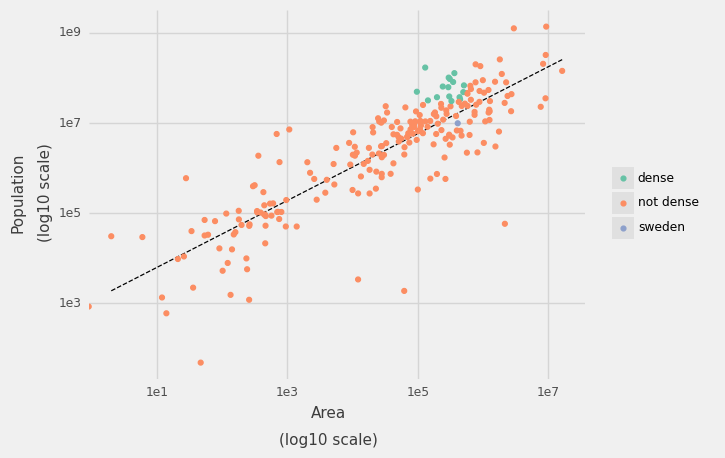

<ggplot: (8784374021077)>

In [58]:
(
gg.ggplot(dense_countries, gg.aes(x='area_land', y='population'))
+gg.geom_smooth(method='lm', se=False, linetype='dashed', size=0.5)
+gg.geom_point(gg.aes(color='category'))
+gg.scales.scale_y_log10()
+gg.scales.scale_color_manual(['#66c2a5','#fc8d62','#8da0cb'])
+gg.scales.scale_x_log10()
+gg.labs(x='Area\n\n(log10 scale)', y='Population\n\n(log10 scale)', color='')
+gg.themes.theme_538()
)

The plot shows that Sweden is not a densely populated country. But has about the same land area as those countries that we've flagged as densely populated.

# Countries with the largest populations

Lets create a plot with the 10 countries with the largest populations and also Sweden for comparison.

In [59]:
world = %sql SELECT name, population/1000000 AS population_millions, 'Rest of the World' AS issweden FROM facts WHERE name !='World' AND name !='European Union' ORDER BY population DESC LIMIT 10;
sweden = %sql SELECT name, population/1000000 AS population_millions, 'Sweden' AS issweden FROM facts WHERE name == 'Sweden'

pop_df = pd.concat([world.DataFrame(), sweden.DataFrame()])

 * sqlite:///factbook.db
 * sqlite:///factbook.db


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


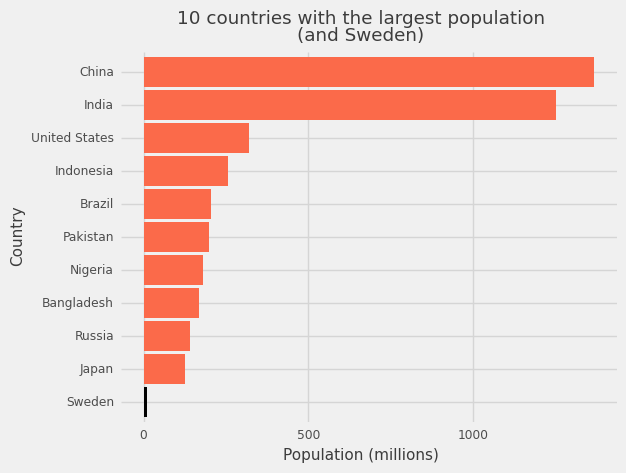

<ggplot: (8784373907089)>

In [60]:
categories = pop_df.sort_values('population_millions')['name']
pop_df['name'] = pd.Categorical(pop_df['name'],  categories=categories, ordered=True)


(
gg.ggplot(pop_df)
+gg.aes(x='name', y='population_millions', fill='issweden')
+gg.geom_col()
+gg.coord_flip()
+gg.themes.theme_538()
+gg.scale_fill_manual(values=['#fb6a4a', 'black'], guide=False)
+gg.labs(x="Country", y="Population (millions)", title="10 countries with the largest population\n(and Sweden)", fill='')
)



The plot shows that populations of China and India is by **far** the largest populations on earth. And the size of Swedens populations is minuscule in comparison.




# Population growth



*   Which countries have the highest population growth rates?



In [61]:
%%sql SELECT name, population_growth
FROM facts
ORDER BY population_growth DESC
LIMIT 10;

 * sqlite:///factbook.db


name,population_growth
South Sudan,4.02
Malawi,3.32
Burundi,3.28
Niger,3.25
Uganda,3.24
Qatar,3.07
Burkina Faso,3.03
Mali,2.98
Cook Islands,2.95
Iraq,2.93


* Which countries have the lowest population growth rates?



In [62]:
%%sql SELECT name, population_growth
FROM facts
WHERE population_growth IS NOT null
ORDER BY population_growth 
LIMIT 10;

 * sqlite:///factbook.db


name,population_growth
Holy See (Vatican City),0.0
Cocos (Keeling) Islands,0.0
Greenland,0.0
Pitcairn Islands,0.0
Greece,0.01
Norfolk Island,0.01
Tokelau,0.01
Falkland Islands (Islas Malvinas),0.01
Guyana,0.02
Slovakia,0.02


Let's see if there is a relationship between population size and population growth.

In [63]:
pop_growth = %sql SELECT name, population_growth, population, CASE WHEN name=='Sweden' THEN 'Sweden' ELSE 'Rest of the World'  END AS issweden FROM facts WHERE population_growth IS NOT null;

 * sqlite:///factbook.db


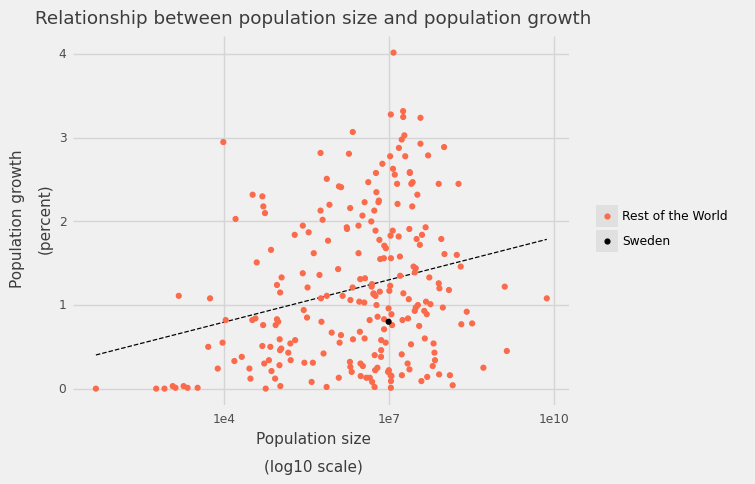

<ggplot: (8784374199129)>

In [64]:
(
gg.ggplot(pop_growth.DataFrame(), gg.aes(x='population', y='population_growth'))
+gg.geom_smooth(method='lm', se=False, linetype='dashed', size=0.5)
+gg.geom_point(gg.aes(color='issweden'))
+gg.scale_color_manual(values=['#fb6a4a', 'black'])
+gg.scales.scale_x_log10()
+gg.labs(x='Population size\n\n(log10 scale)', y='Population growth\n\n(percent)', title="Relationship between population size and population growth", color='')
+gg.themes.theme_538()
)

The plot suggest that **maybe*' countries with larger populations grow at higher growth rates an vice versa. But it's not a perfect relationship.



# Relationship between population growth

Ok. For a final plot lets try to visualize many relationships at once by using the following aesthetics:

* `x` = birth rate (percent)
* `y` = death rate (percent)
* `size` = poulation (millions)
* `color` = population growth (percent)






In [65]:
birth_death_rates = %sql SELECT name, birth_rate, death_rate, population/1000000 AS population_millions, population_growth,  CASE WHEN name=='Sweden' THEN 'Sweden' ELSE 'Rest of the World'  END AS issweden FROM facts WHERE population_growth IS NOT null;



 * sqlite:///factbook.db


/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 8 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


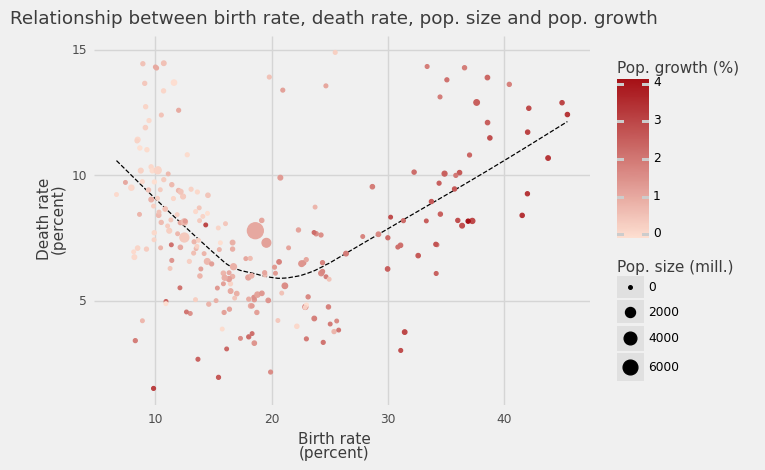

<ggplot: (8784375862373)>

In [66]:
(
gg.ggplot(birth_death_rates.DataFrame(), gg.aes(x='birth_rate', y='death_rate', size='population_millions', color='population_growth'))
+gg.geom_smooth(linetype='dashed', size=0.5)
+gg.geom_point()
+gg.scales.scale_color_gradient(low='#fee0d2', high='#a50f15')
+gg.labs(x='Birth rate\n(percent)', y='Death rate\n(percent)', title="Relationship between birth rate, death rate, pop. size and pop. growth", color='Pop. growth (%)', size='Pop. size (mill.)')
+gg.themes.theme_538()
)

From the plot one can draw the following two conclusions:

* There are three broad categories of countries:
  * Countries with **high** death rates and **low** birth rates
  * Countries with **average** death rates and **average** birth rates
  * Countries with **high** death rates and **high** birth rates

* The factor that seems most determinant on pop. growth is birth rates (higher birthrates = darker color).

<br><br>

That's all for this little project. Feel free to reach out!

# Contact details

![bild](https://avatars.githubusercontent.com/u/99097833?v=4)

Feel free to reach out:

* Twitter: [@vaxjo_kalle](https://twitter.com/vaxjo_kalle) 
* LinkedIn: [My profile](https://www.linkedin.com/in/karlkarlssonvaxjo/)
* E-mail: [karl_karlsson@icloud.com](mailto:karl_karlsson@icloud.com)
* GitHub: [github.com/karl-karlsson](https://github.com/karl-karlsson)